In [4]:
import os
import cv2
import numpy as np
import random
import kagglehub
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
from glob import glob
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
import tifffile as tiff

In [13]:
path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

## 1.2 Preprocessing The Dataset

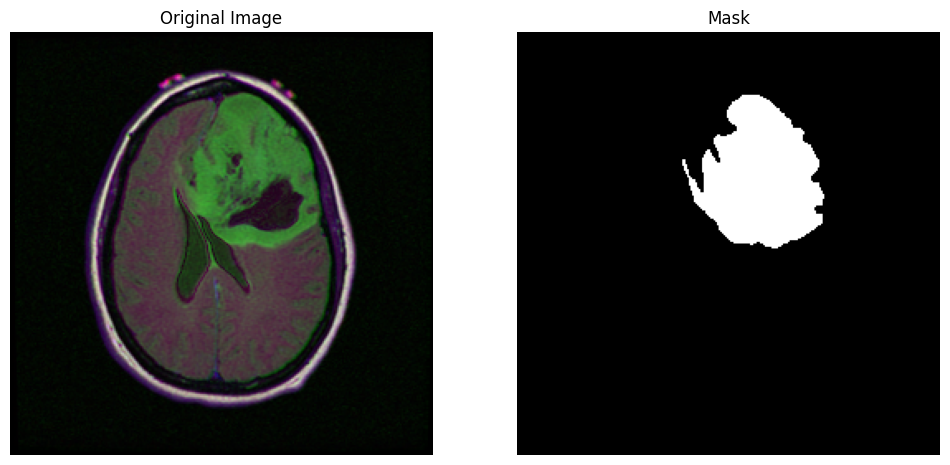

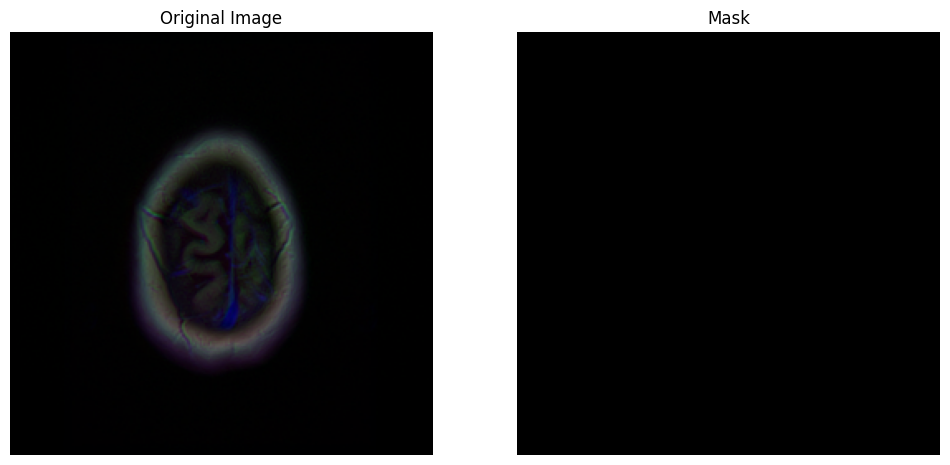

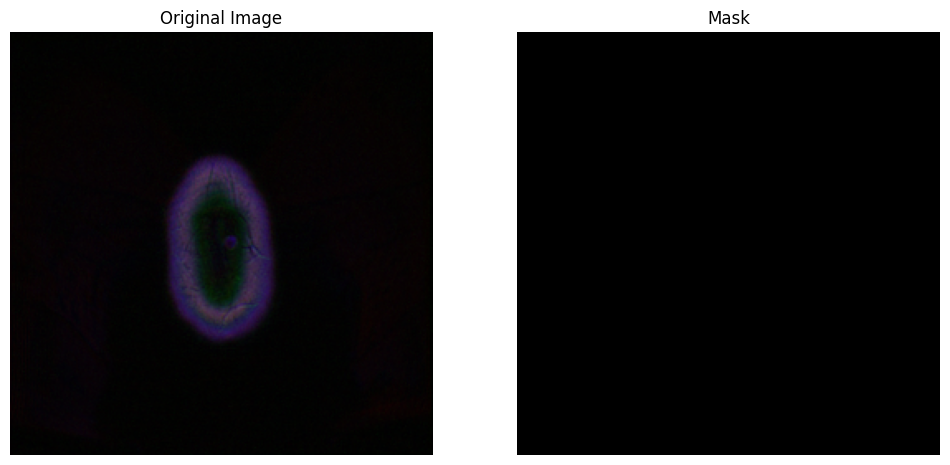

In [14]:
data_dir = path + '/kaggle_3m'

def load_files(data_path):
    image_files = []
    mask_files = []

    for case_folder in os.listdir(data_dir):
        case_folder_path = os.path.join(data_dir, case_folder)

        if os.path.isdir(case_folder_path):
            for file_name in os.listdir(case_folder_path):
                if file_name.endswith('.tif') and '_mask' not in file_name:
                    image_path = os.path.join(case_folder_path, file_name)
                    mask_path = os.path.join(case_folder_path, file_name.replace('.tif', '_mask.tif'))

                    if os.path.exists(mask_path):
                        image_files.append(image_path)
                        mask_files.append(mask_path)
    return image_files, mask_files


def show_image_and_mask(image_path, mask_path):
    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(mask_path))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis('off')

    plt.show()

images, masks = load_files(data_dir)

for i in range(3):
    rand = random. randint(0, len(images))
    show_image_and_mask(images[rand], masks[rand])

In [ ]:

train_images, temp_images, train_masks, temp_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(temp_images, temp_masks, test_size=0.5, random_state=42)


print(f"Number of images in sets")
print(f"Train Images: {len(train_images)} and Train Masks: {len(train_masks)} and Total Train set: {len(train_images)+len(train_masks)}")
print(f"Validation Images: {len(val_images)} and Validation Masks: {len(val_masks)} and Total Validation set: {len(val_images)+len(val_masks)}")
print(f"Test Images: {len(test_images)} and Test Masks: {len(test_masks)} and Total Test set: {len(test_images)+len(test_masks)}")

Number of images in sets
Train Images: 3143 and Train Masks: 3143 and Total Train set: 6286
Validation Images: 393 and Validation Masks: 393 and Total Validation set: 786
Test Images: 393 and Test Masks: 393 and Total Test set: 786


## 1.3 Data Augmentation

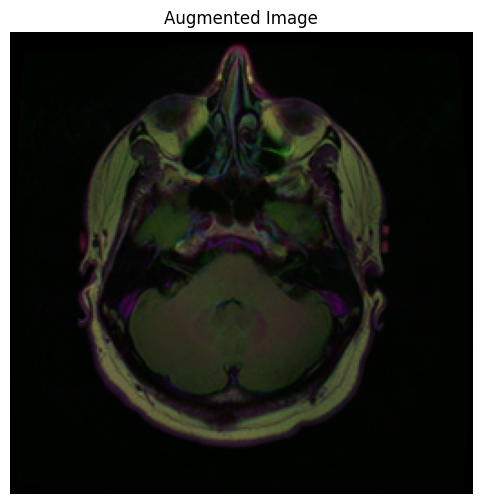

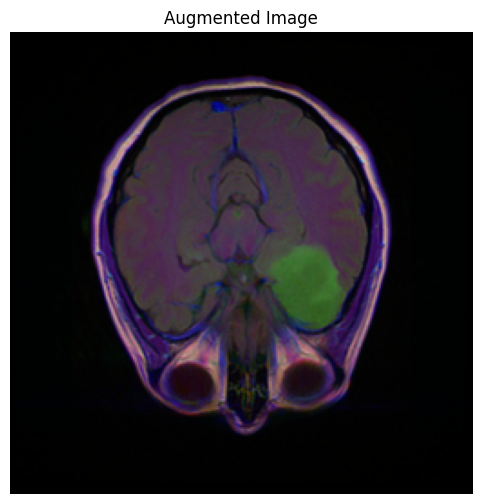

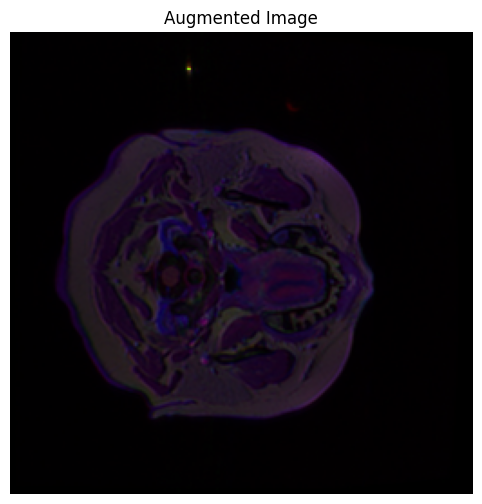

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np

def augment_image(image, mask):
    angle = tf.random.uniform([], minval=-40, maxval=40, dtype=tf.float32)
    image = tf.image.rot90(image, k=tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32))
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.resize(image, [256, 256])
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, [256, 256])
    return image, mask

num_images = 3
for i in range(num_images):
    rand = random.randint(1, len(images))
    image = tiff.imread(images[rand])
    mask = tiff.imread(masks[rand])
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    mask = tf.convert_to_tensor(mask, dtype=tf.float32)
    augmented_image, _ = augment_image(image, mask)
    augmented_image = augmented_image.numpy().astype(np.uint8)
    plt.figure(figsize=(12, 6))
    plt.imshow(augmented_image.squeeze())
    plt.title("Augmented Image")
    plt.axis('off')
    plt.show()


## 1.4 Optimizer, Criteria and Cost Function


In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return (2. * intersection + smooth) / (union + smooth)

def iou_score(y_true, y_pred):
    smooth = 1.0
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    return (intersection + smooth) / (union + smooth)

def accuracy_metric(y_true, y_pred):
    return tf.keras.metrics.binary_accuracy(y_true, y_pred)

## 1.5 Model Implementation

In [ ]:
def build_unet_vgg16(input_shape):
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    vgg16.trainable = False
    # vgg16.get_layer("block5_pool").trainable = False

    enc1 = vgg16.get_layer("block1_pool").output
    enc2 = vgg16.get_layer("block2_pool").output
    enc3 = vgg16.get_layer("block3_pool").output
    enc4 = vgg16.get_layer("block4_pool").output
    bottleneck = vgg16.get_layer("block5_pool").output

    dec4 = UpSampling2D((2, 2))(bottleneck)
    dec4 = Conv2D(512, (3, 3), activation='relu', padding='same')(dec4)
    dec4 = Conv2D(512, (3, 3), activation='relu', padding='same')(dec4)
    dec4 = concatenate([dec4, enc4])

    dec3 = UpSampling2D((2, 2))(dec4)
    dec3 = Conv2D(256, (3, 3), activation='relu', padding='same')(dec3)
    dec3 = Conv2D(256, (3, 3), activation='relu', padding='same')(dec3)
    dec3 = concatenate([dec3, enc3])

    dec2 = UpSampling2D((2, 2))(dec3)
    dec2 = Conv2D(128, (3, 3), activation='relu', padding='same')(dec2)
    dec2 = Conv2D(128, (3, 3), activation='relu', padding='same')(dec2)
    dec2 = concatenate([dec2, enc2])

    dec1 = UpSampling2D((2, 2))(dec2)
    dec1 = Conv2D(64, (3, 3), activation='relu', padding='same')(dec1)
    dec1 = Conv2D(64, (3, 3), activation='relu', padding='same')(dec1)
    dec1 = concatenate([dec1, enc1])

    dec0 = UpSampling2D((2, 2))(dec1)
    dec0 = Conv2D(32, (3, 3), activation='relu', padding='same')(dec0)
    dec0 = Conv2D(32, (3, 3), activation='relu', padding='same')(dec0)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(dec0)

    model = Model(inputs=vgg16.input, outputs=outputs)
    return model

input_shape = (256, 256, 3)
model = build_unet_vgg16(input_shape)

## 1.6 Model Training

In [ ]:
def augment_image(image, mask):
    image = image / 255.0
    angle = tf.random.uniform([], minval=-20, maxval=20, dtype=tf.float32)
    image = tf.image.rot90(image, k=tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32))
    image = tf.image.random_brightness(image, max_delta=0.05)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.resize(image, [256, 256])
    mask = tf.image.resize(mask, [256, 256])
    return image, mask

def data_generator(image_paths, mask_paths, batch_size, augment=True):
    while True:
        images = []
        masks = []
        indices = np.random.permutation(len(image_paths))
        image_paths = np.array(image_paths)[indices]
        mask_paths = np.array(mask_paths)[indices]

        for i in range(batch_size):
            image = tiff.imread(image_paths[i])
            mask = tiff.imread(mask_paths[i])

            image = tf.convert_to_tensor(image, dtype=tf.float32)
            mask = tf.convert_to_tensor(mask, dtype=tf.float32)

            mask = mask / 255.0

            if len(image.shape) == 2:
                image = tf.expand_dims(image, axis=-1)
            if len(mask.shape) == 2:
                mask = tf.expand_dims(mask, axis=-1)

            if augment:
                image, mask = augment_image(image, mask)

            images.append(image)
            masks.append(mask)

        yield tf.stack(images), tf.stack(masks)

train_gen = data_generator(train_images, train_masks, batch_size=32, augment=True)
val_gen = data_generator(val_images, val_masks, batch_size=32, augment=False)

In [ ]:
epoch = 20
batch_sizes = 32

model.compile(optimizer=Adam(learning_rate=0.001), loss=dice_loss, metrics=[dice_coefficient, iou_score])

history = model.fit(train_gen, steps_per_epoch=len(train_images) // batch_sizes,
                    epochs=epoch, validation_data=val_gen,
                    validation_steps=len(val_images) // batch_sizes)


Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - dice_coefficient: 0.5883 - iou_score: 0.5871 - loss: 0.4117 - val_dice_coefficient: 0.6907 - val_iou_score: 0.6907 - val_loss: 0.3093
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 67s 677ms/step - dice_coefficient: 0.6385 - iou_score: 0.6385 - loss: 0.3615 - val_dice_coefficient: 0.6488 - val_iou_score: 0.6488 - val_loss: 0.3512
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 70s 716ms/step - dice_coefficient: 0.6423 - iou_score: 0.6423 - loss: 0.3577 - val_dice_coefficient: 0.6620 - val_iou_score: 0.6620 - val_loss: 0.3380
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 67s 682ms/step - dice_coefficient: 0.6442 - iou_score: 0.6442 - loss: 0.3558 - val_dice_coefficient: 0.6700 - val_iou_score: 0.6700 - val_loss: 0.3300
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 66s 682ms/step - dice_coefficient: 0.6493 - iou_score: 0.6493 - loss: 0.3507 - val_dice_coefficient: 0.6698 - val_iou_score: 0.6698 - val_loss: 0.3302
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 75s 772ms/step - d

## 1.7 Model Evaluation

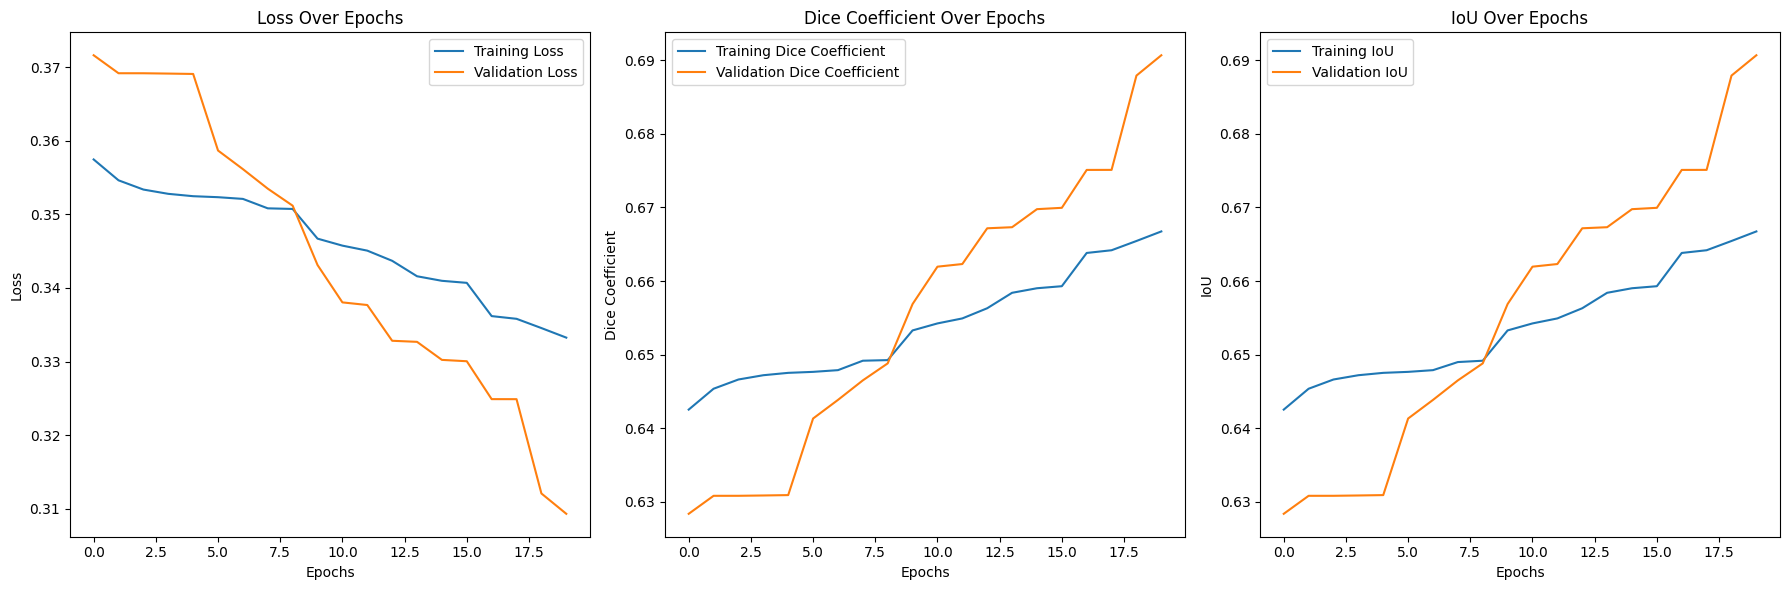

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_dice = history.history['dice_coefficient']
val_dice = history.history['val_dice_coefficient']
train_iou = history.history['iou_score']
val_iou = history.history['val_iou_score']

epochs_range = range(epoch)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_dice, label='Training Dice Coefficient')
plt.plot(epochs_range, val_dice, label='Validation Dice Coefficient')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_iou, label='Training IoU')
plt.plot(epochs_range, val_iou, label='Validation IoU')
plt.title('IoU Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()


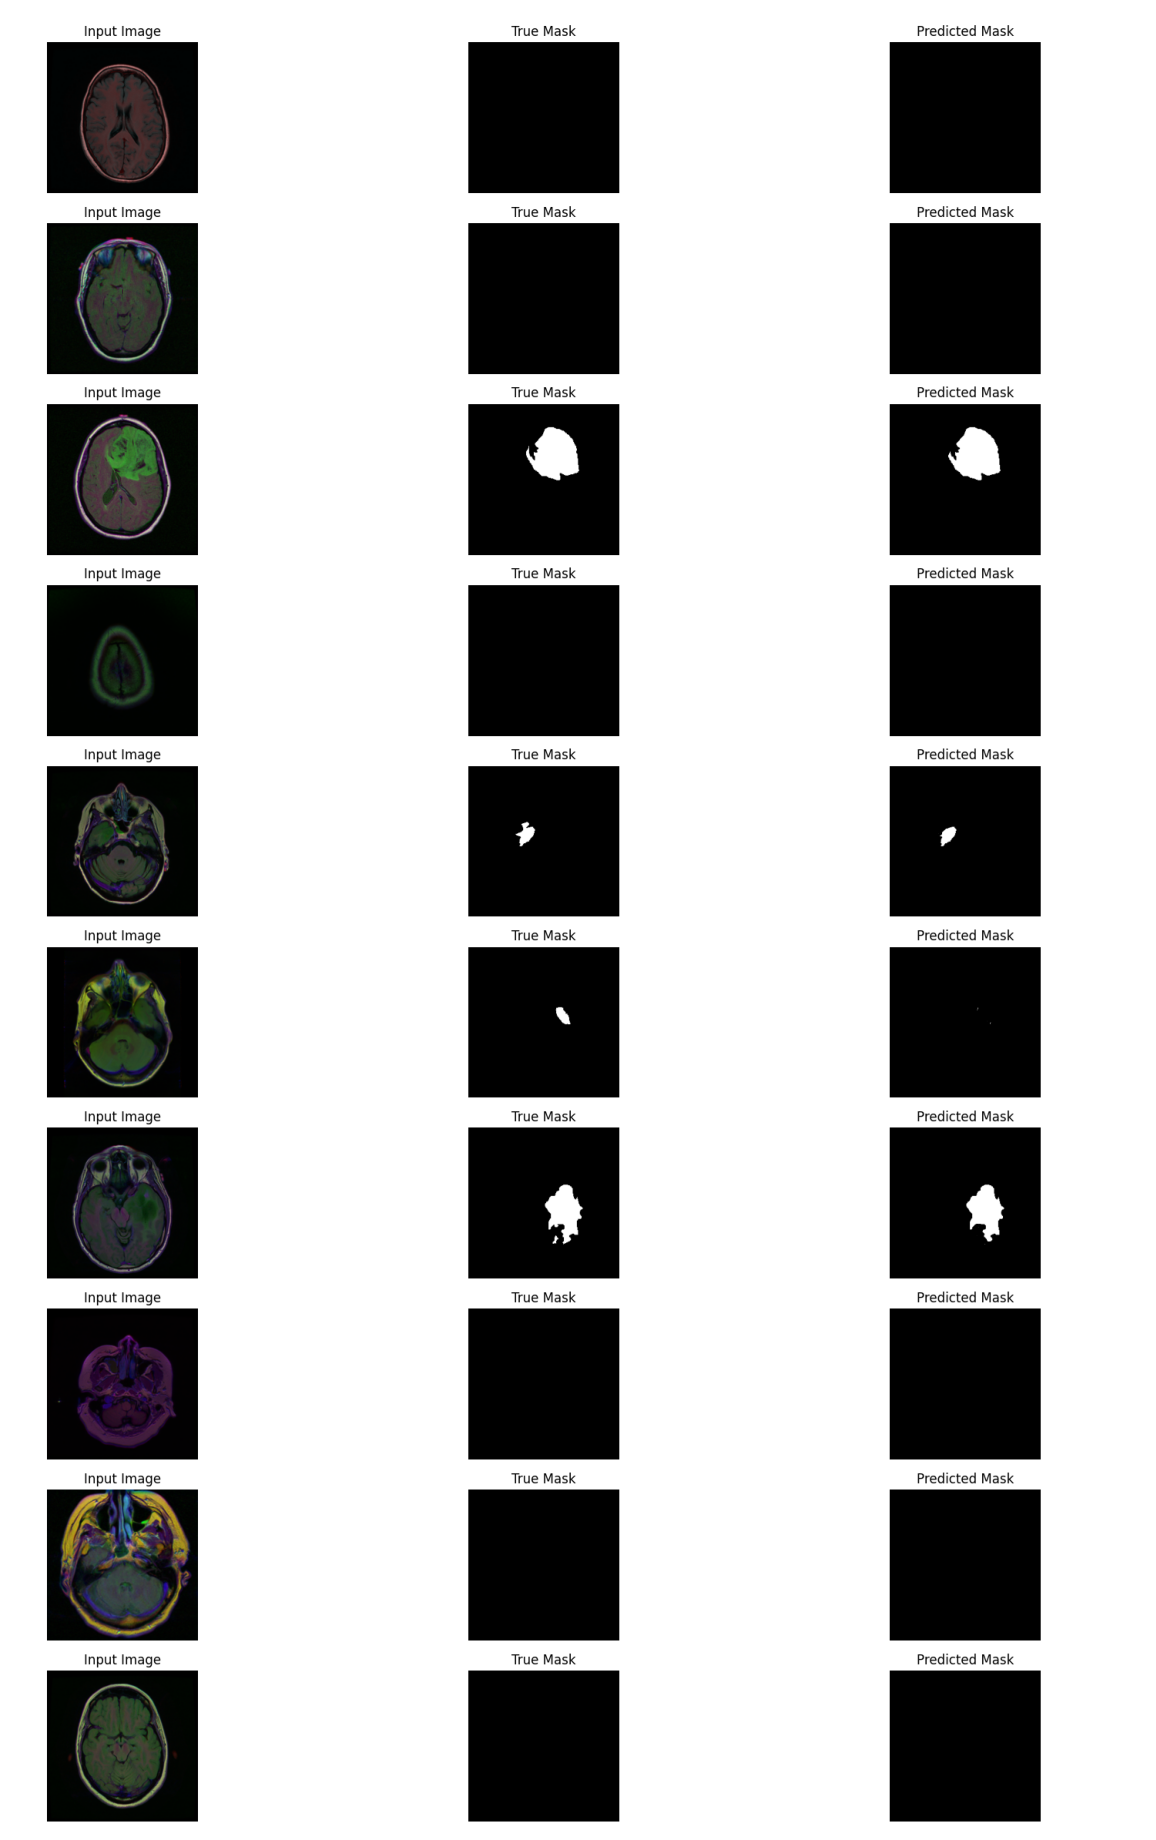

In [3]:

test_gen = data_generator(test_images, test_masks, batch_size=10, augment=False)

test_imgs, test_masks_true = next(test_gen)

test_masks_pred = model.predict(test_imgs)

plt.figure(figsize=(20, 30))
for i in range(10):
    plt.subplot(10, 3, i * 3 + 1)
    plt.imshow(test_imgs[i].numpy().astype('uint8'))
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(10, 3, i * 3 + 2)
    plt.imshow(test_masks_true[i].numpy().squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis("off")

    plt.subplot(10, 3, i * 3 + 3)
    plt.imshow((test_masks_pred[i].squeeze() > 0.3).astype('uint8'), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()
